# Proyecto 1: Entendimiento de los datos con PySpark (Divipola).

## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python
necesarios

In [45]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
from pyspark.sql.functions import trim
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
from collections import Counter
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import numpy as np
import os

Configuración del controlador e inicio de sesion Spark



In [5]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [6]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\pyspark\sql\context.py:115: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [7]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/ProyectoTransaccional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_103_202413'
db_psswd = 'MISO_aabb1122'

PATH='./'

### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos (archivo csv o base de datos) y retornar un dataframe que es el que se utilizará posteriormente para manipular los datos.

In [8]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

### Resumen

A partir de los resultados de actividades previas, debes hacer el entendimiento de los datos de una fuente de datos. El detalle lo encuentras en la guía de la tarea del entendimiento de los datos.  Utiliza  como ejemplo la infografía compartida del tema de entendimiento de datos. 

### Perfilamiento de datos

#### Cargue de datos
Para consultar desde la base de datos se puede acceder directamente a la tabla dado su nombre o se puede especificar la sentencia SQL de un "SELECT" completo para traer la información total o parcial de la tabla que se requiere. A continuación un ejemplo de cada uno de estos usos. 
Acceso directo para el caso de órdenes y acceso con sentencia SQL para el caso de movimientosCopia.

## Tabla Divipola

In [9]:
sql_divipola = 'ProyectoTransaccional.divipolaCopia'

In [10]:
divipola = obtener_dataframe_de_bd(db_connection_string, sql_divipola, db_user, db_psswd)

divipola.show(5)

+-------------------+----------------+---------------------+-------------------+----------------+---------------------+-------------------+--------------+--------------+---------------+----------------------------------------+-------------------------+
|Código Departamento|Código Municipio|Código Centro Poblado|Nombre Departamento|Nombre Municipio|Nombre Centro Poblado|Tipo Centro Poblado|      Longitud|       Latitud|Nombre Distrito|Municipio/Áreas No Municipalizadas (ANM)|Nombre Área Metropolitana|
+-------------------+----------------+---------------------+-------------------+----------------+---------------------+-------------------+--------------+--------------+---------------+----------------------------------------+-------------------------+
|                 41|           91001|             91001033|           amazonas|           NEIVA| COMUNIDAD INDÍGEN...|     CENTRO POBLADO|-70.0285785394|-4.11198257304|               |                               MUNICIPIO|               

#### Generación de reporte con Pandas Profiling
Con el fin de generar un apoyo visual de alguna de la información que se presentará más adelante, se hará utilizará la herramienta Pandas Profiling para generar un reporte que contiene información general de la tabla <i>movimientosCopia</i>, información de las columnas que la componen, y representación graficas de estadísticas como histogramas, diagramas de interacción y correlación, que guardaremos en un reporte en HTML llamado <i>divipola_reporte_perfilamiento.html</>.

Para generar nuestro reporte ejecutaremos:

In [65]:
PATH='./'
reporte = ProfileReport(divipola.toPandas())

In [66]:
reporte.to_file(PATH+"divipola_reporte_perfilamiento.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s]


#### Cantidad de registros y cantidad de columnas por tipo de dato


#### Tabla divipola

Para obtener la cantidad de registros, el tipo de cada columna y el número de columnas de la tabla `divipola`, se utilizan las funciones `dtypes`, `count` y `columns` del dataframe. 

In [29]:
print(f"Registros = {divipola.count()}", f", columnas = {len(divipola.columns)}")

Registros = 9508 , columnas = 12


Tambien podemos comparar la información del número de columnas obtenido y el número total de registros en la tabla `divipola` a través del detalle generado por el reporte HTML con Pandas Profiling, más específicamente la sección de <i>Overview</i>. 

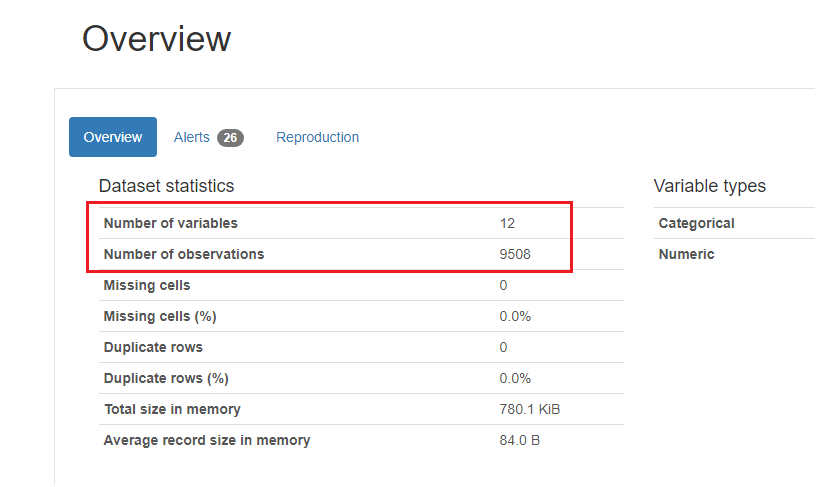

In [27]:
print("En la siguiente impresion se puede ver los tipos de datos de la tabla extraida")
for field in divipola.schema.fields:
    print(field.name +" , "+str(field.dataType))

En la siguiente impresion se puede ver los tipos de datos de la tabla extraida
Código Departamento , IntegerType()
Código Municipio , IntegerType()
Código Centro Poblado , IntegerType()
Nombre Departamento , StringType()
Nombre Municipio , StringType()
Nombre Centro Poblado , StringType()
Tipo Centro Poblado , StringType()
Longitud , DoubleType()
Latitud , DoubleType()
Nombre Distrito , StringType()
Municipio/Áreas No Municipalizadas (ANM) , StringType()
Nombre Área Metropolitana , StringType()


In [25]:
Counter([col[1] for col in divipola.dtypes])

Counter({'int': 3, 'string': 7, 'double': 2})

Resumiendo la tabla `divipola` tiene un total de 12 columnas, de las cuales hay 3 de tipo int, 2 de tipo double y 7 de tipo string. Adicional a esto actualmente hay 9508 registros en esta tabla.

#### Significado de una fila


#### Tabla divipola

Para describir el significado de una fila en la tabla de `divipola`, se mostraran algunos registros y se realizara un agrupamiento utilizando las columnas:
* `Nombre Departamento` con el fin de identificar cuantos municipios hacen parte de estos.
* `Nombre Municipio` con el fin de identificar cuantos centros poblados hacen parte de estos.
* `Tipo Centro Poblado` con el fin de identificar cuantos tipos existen.
* `Municipio/Áreas No Municipalizadas (ANM)|Nombre Área Metropolitana` con el fin de identificar cuantos registros existen por cada tipo.

In [36]:
divipola.show(5)

+-------------------+----------------+---------------------+-------------------+----------------+---------------------+-------------------+--------------+--------------+---------------+----------------------------------------+-------------------------+
|Código Departamento|Código Municipio|Código Centro Poblado|Nombre Departamento|Nombre Municipio|Nombre Centro Poblado|Tipo Centro Poblado|      Longitud|       Latitud|Nombre Distrito|Municipio/Áreas No Municipalizadas (ANM)|Nombre Área Metropolitana|
+-------------------+----------------+---------------------+-------------------+----------------+---------------------+-------------------+--------------+--------------+---------------+----------------------------------------+-------------------------+
|                 41|           91001|             91001033|           amazonas|           NEIVA| COMUNIDAD INDÍGEN...|     CENTRO POBLADO|-70.0285785394|-4.11198257304|               |                               MUNICIPIO|               

Otra forma de validar, pero de forma más visual que la información resultante de la consulta anterior es correcta, es a través del detalle generado por el reporte HTML con Pandas Profiling, más específicamente la sección de <i>Overview</i> - <i>Sample</i>. 

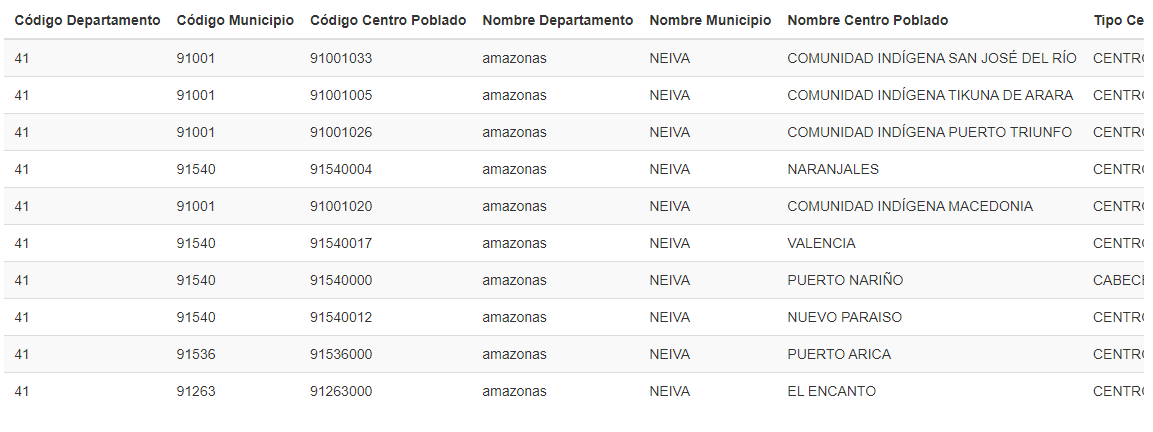

In [37]:
divipola.groupby("Nombre Departamento").count().orderBy("count", ascending=False).show(10)

+-------------------+-----+
|Nombre Departamento|count|
+-------------------+-----+
|          ANTIOQUIA|  734|
|           el valle|  531|
|             NARIÑO|  513|
|            CORDOBA|  506|
|       CUNDINAMARCA|  454|
|            BOLIVAR|  429|
|              CHOCO|  390|
|              CAUCA|  387|
|              SUCRE|  352|
|           santande|  315|
+-------------------+-----+
only showing top 10 rows



In [38]:
divipola.groupby("Nombre Municipio").count().orderBy("count", ascending=False).show(10)

+----------------+-----+
|Nombre Municipio|count|
+----------------+-----+
|           NEIVA| 9508|
+----------------+-----+



In [39]:
divipola.groupby("Tipo Centro Poblado").count().orderBy("count", ascending=False).show(10)

+-------------------+-----+
|Tipo Centro Poblado|count|
+-------------------+-----+
|     CENTRO POBLADO| 8169|
| CABECERA MUNICIPAL| 1339|
+-------------------+-----+



In [41]:
divipola.groupby("Municipio/Áreas No Municipalizadas (ANM)").count().orderBy("count", ascending=False).show(10)

+----------------------------------------+-----+
|Municipio/Áreas No Municipalizadas (ANM)|count|
+----------------------------------------+-----+
|                               MUNICIPIO| 9476|
|                    AREA NO MUNICIPAL...|   26|
|                                    ISLA|    6|
+----------------------------------------+-----+



Como resultado de las consultas anteriormente realizadas a la tabla `divipola`, se puede inferir que en esta tabla se almacena toda información asociada a la `división político-administrativa` de Colombia, es decir se encuentra la codificación y clasificación de las unidades territoriales y administrativas del país. Tambien se observa que toda la información registrada en la tabla `divipola` solo corresponde al munipio `NEIVA`, es decir todos los 9508 registros que identificaron en el apartado 1.1 corresponden a este unico municipio, por lo que surge duda, de si la información suministrada por el negocio esta incompleta y se debe solicitar nuevamente.

#### Estadisticas descriptivas por columna (numérica, categórica, fechas) 

#### Tabla divipola

Para la generación de las estadísticas descriptivas por columna de la tabla de `divipola`, se ejecuta el comando de `summary`

##### Columnas numéricas

In [45]:
df_divipola_col_nums = divipola.select('Código Departamento', 'Código Municipio', 'Código Centro Poblado', "Longitud", 'Latitud')
df_divipola_col_nums.summary().show()

+-------+-------------------+------------------+---------------------+------------------+------------------+
|summary|Código Departamento|  Código Municipio|Código Centro Poblado|          Longitud|           Latitud|
+-------+-------------------+------------------+---------------------+------------------+------------------+
|  count|               9508|              9508|                 9508|              9508|              9508|
|   mean|               41.0| 40581.06994110223| 4.0581083873159446E7|-74.58826264179658| 5.503320507854293|
| stddev|                0.0|26073.879984952444|  2.607388262641055E7| 4.214896199193669|3.6691444969329488|
|    min|                 41|              5001|              5001000|    -81.7300009044|    -4.19469878932|
|    25%|                 41|             19100|             19100020|    -76.3551928772|     3.01605390077|
|    50%|                 41|             27615|             27615023|    -75.1846870877|     5.44661322782|
|    75%|          

En las estadísticas anteriores vemos que las columnas numéricas `Código Departamento`, `Código Municipio` y `Código Centro Poblado`, son identificadores por lo que realizar un cálculo como el mínimo, máximo y desviación estándar no tienen mucho sentido y no aportan nada para el analisis en cuestión, esto mismo ocurre con las columnas `Longitud` y `Latitud` ya que estas corresponden a las ubicaciones asociadas a cada centro poblado. Por otra parte se puede evidenciar que dichos campos numéricos se encuentran con información, ya que el conteo es el mismo del número total de registros, lo que nos indica un porcentaje del 0% de valores nulos o vacios para esos campos.

##### Columnas categóricas

In [18]:
df_divipola_col_str = divipola.select('Nombre Departamento', 'Nombre Municipio', 'Nombre Centro Poblado', "Tipo Centro Poblado", 'Nombre Distrito', 'Municipio/Áreas No Municipalizadas (ANM)', 'Nombre Área Metropolitana')
df_divipola_col_str.distinct().show(5)

+-------------------+----------------+---------------------+-------------------+---------------+----------------------------------------+-------------------------+
|Nombre Departamento|Nombre Municipio|Nombre Centro Poblado|Tipo Centro Poblado|Nombre Distrito|Municipio/Áreas No Municipalizadas (ANM)|Nombre Área Metropolitana|
+-------------------+----------------+---------------------+-------------------+---------------+----------------------------------------+-------------------------+
|             nariño|           NEIVA|            LAS MESAS|     CENTRO POBLADO|               |                               MUNICIPIO|                         |
|              huila|           NEIVA|              MORELIA|     CENTRO POBLADO|               |                               MUNICIPIO|                         |
|           guaviare|           NEIVA|         PUERTO NUEVO|     CENTRO POBLADO|               |                               MUNICIPIO|                         |
|    valle del c

In [25]:
df_municipios = df_divipola_col_str.groupby('Nombre Departamento').count().orderBy("count", ascending=False).show(10)

+-------------------+-----+
|Nombre Departamento|count|
+-------------------+-----+
|          ANTIOQUIA|  734|
|           el valle|  531|
|             NARIÑO|  513|
|            CORDOBA|  506|
|       CUNDINAMARCA|  454|
|            BOLIVAR|  429|
|              CHOCO|  390|
|              CAUCA|  387|
|              SUCRE|  352|
|           santande|  315|
+-------------------+-----+
only showing top 10 rows



Tambien podemos comparar la información obtenida anteriormente a través del detalle generado por el reporte HTML con Pandas Profiling, más específicamente la sección de <i>Variables</i> - <i>Nombre Departamento</i>. 

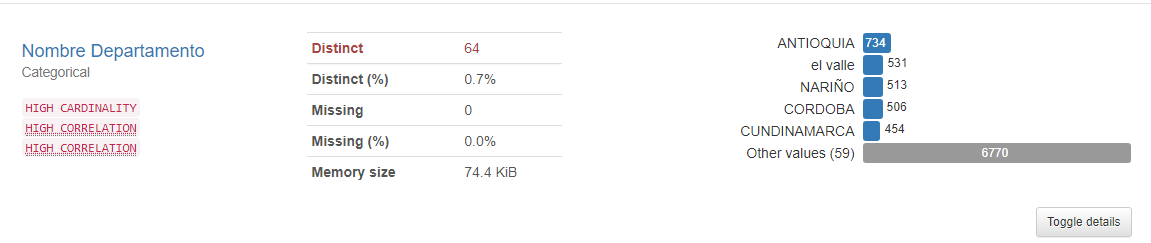

In [51]:
df_municipios = df_divipola_col_str.groupby('Nombre Municipio').count().show()

+----------------+-----+
|Nombre Municipio|count|
+----------------+-----+
|           NEIVA| 9508|
+----------------+-----+



Tambien podemos comparar la información obtenida anteriormente a través del detalle generado por el reporte HTML con Pandas Profiling, más específicamente la sección de <i>Variables</i> - <i>Nombre Municipio</i>. 

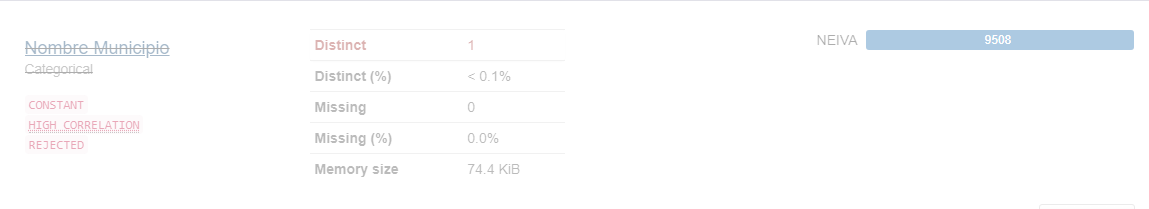

In [22]:
df_centro_poblado  = df_divipola_col_str.groupby('Nombre Centro Poblado').count().orderBy("count", ascending=False).show(5)

+---------------------+-----+
|Nombre Centro Poblado|count|
+---------------------+-----+
|         PUEBLO NUEVO|   51|
|          SAN ANTONIO|   37|
|           SANTA ROSA|   35|
|           SAN ISIDRO|   34|
|             SAN JOSÉ|   34|
+---------------------+-----+
only showing top 5 rows



Tambien podemos comparar la información obtenida anteriormente a través del detalle generado por el reporte HTML con Pandas Profiling, más específicamente la sección de <i>Variables</i> - <i>Nombre Centro Poblado</i>. 

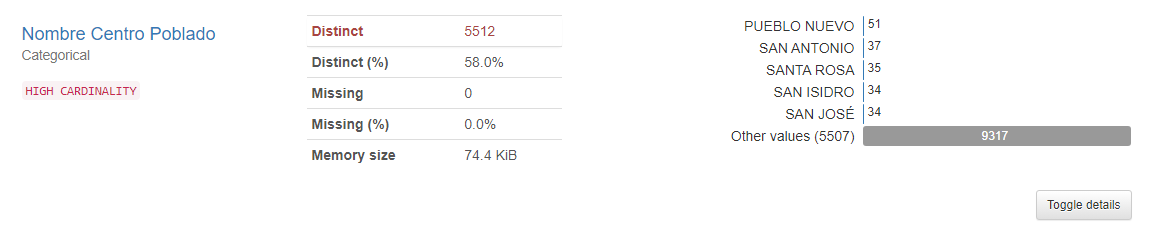

In [61]:
df_tipo_centro_poblado = df_divipola_col_str.groupby('Tipo Centro Poblado').count().show()

+-------------------+-----+
|Tipo Centro Poblado|count|
+-------------------+-----+
| CABECERA MUNICIPAL| 1339|
|     CENTRO POBLADO| 8169|
+-------------------+-----+



Tambien podemos comparar la información obtenida anteriormente a través del detalle generado por el reporte HTML con Pandas Profiling, más específicamente la sección de <i>Variables</i> - <i>Tipo Centro Poblado</i>. 

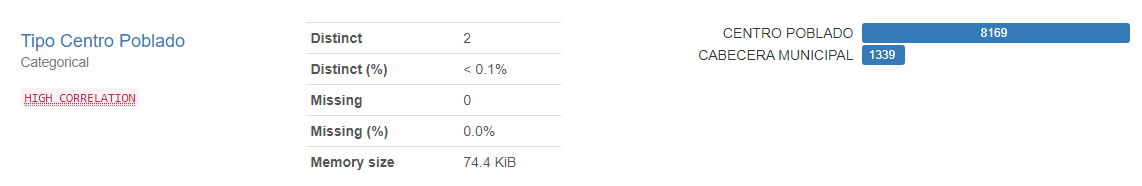

In [62]:
df_distrito = df_divipola_col_str.groupby('Nombre Distrito').count().show()

+--------------------+-----+
|     Nombre Distrito|count|
+--------------------+-----+
|BARRANQUILLA, DIS...|    1|
|SANTIAGO DE CALI,...|   61|
|SANTA CRUZ DE MOM...|   31|
|CARTAGENA DE INDI...|   40|
|TURBO, DISTRITO E...|   43|
|SANTA MARTA, DIST...|   36|
|RÍOHACHA, DISTRIT...|   36|
|BOGOTÁ, DISTRITO ...|   14|
|                    | 9134|
|BUENAVENTURA, DIS...|  112|
+--------------------+-----+



Tambien podemos comparar la información obtenida anteriormente a través del detalle generado por el reporte HTML con Pandas Profiling, más específicamente la sección de <i>Variables</i> - <i>Nombre Distrito</i>. 

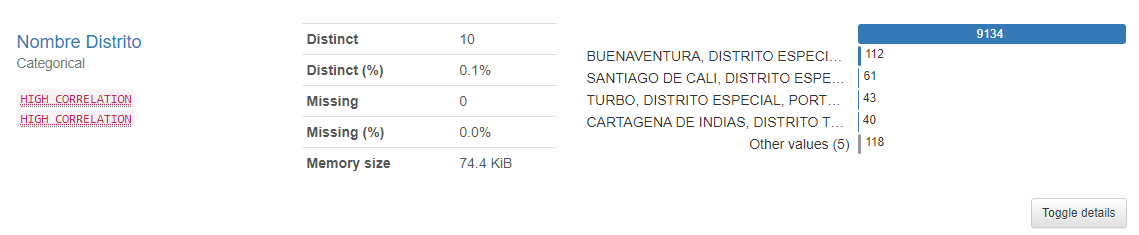

In [63]:
df_areas = df_divipola_col_str.groupby('Municipio/Áreas No Municipalizadas (ANM)').count().show()

+----------------------------------------+-----+
|Municipio/Áreas No Municipalizadas (ANM)|count|
+----------------------------------------+-----+
|                               MUNICIPIO| 9476|
|                    AREA NO MUNICIPAL...|   26|
|                                    ISLA|    6|
+----------------------------------------+-----+



Tambien podemos comparar la información obtenida anteriormente a través del detalle generado por el reporte HTML con Pandas Profiling, más específicamente la sección de <i>Variables</i> - <i>Municipio/Áreas No Municipalizadas (ANM)</i>. 

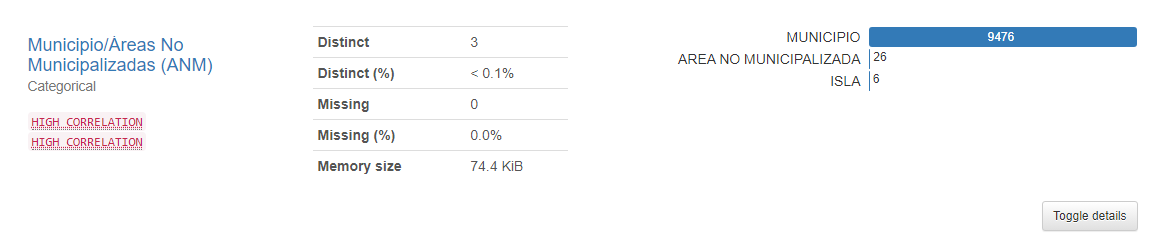

In [64]:
df_area_metropolitana = df_divipola_col_str.groupby('Nombre Área Metropolitana').count().show()

+-------------------------+-----+
|Nombre Área Metropolitana|count|
+-------------------------+-----+
|     AREA METROPOLITAN...|   71|
|     AREA METROPOLITAN...|   74|
|     AREA METROPOLITAN...|  158|
|     AREA METROPOLITAN...|   52|
|     AREA METROPOLITAN...|   12|
|     AREA METROPOLITAN...|  113|
|                         | 9028|
+-------------------------+-----+



Tambien podemos comparar la información obtenida anteriormente a través del detalle generado por el reporte HTML con Pandas Profiling, más específicamente la sección de <i>Variables</i> - <i>Nombre Área Metropolitana</i>. 

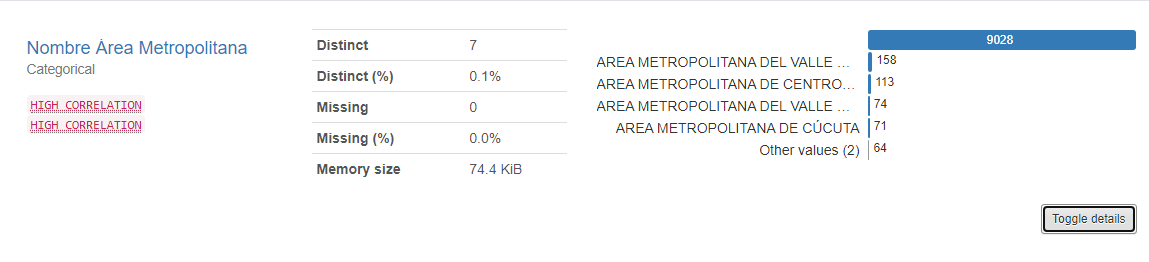

Con el analisis descriptivo anterior se pueden extraer las siguientes conclusiones:

- La tabla `divipola` solo tiene información asociada al municipio `NEIVA`.
- Existen muchos registros con cadenas vacías. Esto se puede evidenciar más que todo en las columnas `Nombre Distrito` y `Nombre Área Metropolitana`.
- Existen errores asociados al nombramiento de los departamentos, ya que hay nombres que inician en minúsculas, otros en mayúsculas, hay nombramientos incorrectos como es el caso de `uila`, `norte de`, `bogota, d0, c0,`, entre otros.

### Analisis de Calidad de los Datos

### Tabla divipola

#### Unicidad y validez

La unicidad se valida comprobando si existen unidades territoriales repetidas o identicas.

In [34]:
divipolas_totales = divipola.count()
divipolas_distintas = divipola.distinct().count()
divipolas_repetidas = divipolas_totales - divipolas_distintas
print("Unidades territoriales totales: " + str(divipolas_totales))
print("Unidades territoriales distintas: " + str(divipolas_distintas))
print("Unidades territoriales repetidas: " + str(divipolas_repetidas))

Unidades territoriales totales: 9508
Unidades territoriales distintas: 9508
Unidades territoriales repetidas: 0


Del conteo anterior se puede observar que en la tabla `divipola` no existen unidades territoriales y administrativas que se encuentren repetivas.

##### Duplicados Lógicos

Para los duplicados lógicos se validó unicamente la información consignada en la columna `Código Centro Poblado`, ya que según la definición del negocio solo puede existir un corregimiento y centro poblado con un identificador único y esto es a nivel nacional.

In [44]:
divipola.groupby("Código Centro Poblado").count().filter(col("count") > 1).show(10)

+---------------------+-----+
|Código Centro Poblado|count|
+---------------------+-----+
|              5138002|    2|
|             54720005|    2|
|             44098001|    2|
|             52835104|    2|
|             76275019|    2|
|             44001005|    2|
|             19807007|    2|
|             52381011|    2|
|             73443006|    2|
|             25224000|    2|
+---------------------+-----+
only showing top 10 rows



In [57]:
import math

df_codigo_poblado = divipola.select('Código Centro Poblado')
codigos_poblado_distintos = df_codigo_poblado.distinct().count()
codigos_poblado_repetidos= df_codigo_poblado.count() - codigos_poblado_distintos
porcentaje_poblados_repetidos = math.ceil(codigos_poblado_repetidos / divipolas_totales * 100)

print("Unidades territoriales totales: " + str(divipolas_totales))
print("Unidades territoriales con códigos de centro poblado distintos: " + str(codigos_poblado_distintos))
print("Unidades territoriales con códigos de centro poblado repetidos: " + str(codigos_poblado_repetidos))
print("% de unidades territoriales con códigos de centro poblado repetidos: " + str(porcentaje_poblados_repetidos) + '%')

Unidades territoriales totales: 9508
Unidades territoriales con códigos de centro poblado distintos: 7879
Unidades territoriales con códigos de centro poblado repetidos: 1629
% de unidades territoriales con códigos de centro poblado repetidos: 18%


Como se puede evidenciar existe un 18% de registros que tiene repetidos la columna `Código Centro Poblado`, lo que indica que existe una incositencia con los datos entregados por el negocio, ya que según la cognotación que existe en la definición de la unidades territoriales y administrativas de Colombia, el `Código Centro Poblado` esta compuesto por los cinco dígitos del municipio más digitos adicionales lo que permite crear un identificador único a nivel nacional, por lo tanto aunque diferentes corregimientos o centros poblados pueden tener nombres similares o idénticos, sus códigos DIVIPOLA serán distintos, garantizando así que no haya duplicación de identificadores

Lo anterior es una muestra de los registros duplicados en la tabla `divipola`.

### Completitud y validez

In [49]:
# Función que permite contar si existen registros vacíos
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(
            (df[c].isNull()) | 
            (df[c] == 'NULL') | 
            (df[c] == 'null') | 
            (f.length(df[c]) == 0)
        ).count()
        if vacios != 0:
            print('Número de vacíos para columna ' + c + ': ' + str(vacios))
            resultados.append((c, vacios))
    return resultados

columnas_vacias_movimientos = contar_vacios(divipola)
print('Columnas con vacíos: ')
print(columnas_vacias_movimientos)

Número de vacíos para columna Nombre Distrito: 9134
Número de vacíos para columna Nombre Área Metropolitana: 9028
Columnas con vacíos: 
[('Nombre Distrito', 9134), ('Nombre Área Metropolitana', 9028)]


Otra forma de validar, pero de forma más visual que la información resultante de la consulta anterior es correcta, es a través del detalle generado por el reporte HTML con Pandas Profiling, más específicamente la sección de la variable <i>Nombre Distrito</i> y <i>Nombre Área Metropolitana</i>. 

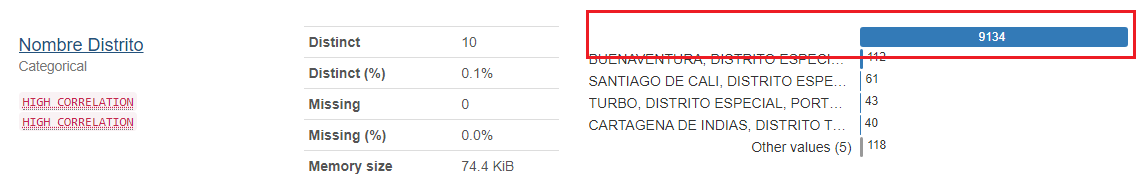

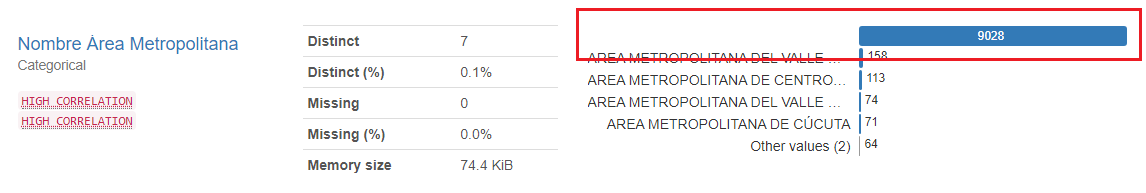


### Consistencia

#### Tabla divipola

A nivel de consistencia para la tabla `divipola` se validara que la información consignada referente a los códigos y los nombres de Departamento y Municipio coincidan.

In [52]:
divipola.select(col('Código Departamento'), col('Nombre Departamento')).distinct().show(10)

+-------------------+--------------------+
|Código Departamento| Nombre Departamento|
+-------------------+--------------------+
|                 41|              caldas|
|                 41|              vaupes|
|                 41|archipielago de s...|
|                 41|                uila|
|                 41|           santander|
|                 41|           ATLANTICO|
|                 41|               amazX|
|                 41|           risaralda|
|                 41|           vaupeszsx|
|                 41|              GUANIA|
+-------------------+--------------------+
only showing top 10 rows



In [53]:
divipola.select(col('Código Municipio'), col('Nombre Municipio')).distinct().show(10)

+----------------+----------------+
|Código Municipio|Nombre Municipio|
+----------------+----------------+
|           41020|           NEIVA|
|           15599|           NEIVA|
|            5030|           NEIVA|
|           20710|           NEIVA|
|           52885|           NEIVA|
|            5819|           NEIVA|
|           15097|           NEIVA|
|           76606|           NEIVA|
|           63470|           NEIVA|
|           25745|           NEIVA|
+----------------+----------------+
only showing top 10 rows



Con base a las anteriores consultas se observan 3 problemas asociados a la consistencia de la información suministrada por el negocio:

- En la tabla `divipola` existe únicamente el `Código Departamento` `41`, sin embargo, asociados a ese código de departamento existen varios nombres, lo cual es una inconsistencia bastante grande, ya que en Colombia cada departamento tiene un código DANE único, y para este caso el código `41` correspondería a departamento del `Huila`;

- En la tabla `divipola` existe únicamente el `Nombre Municipio` `NEIVA`, sin embargo, asociados a este nombre existen varios `Código Municipio`, y esto no debería ser así, debido a que por ejemplo el `Código Municipio` `41020` según el listado de códigos DANE correspondería a `ALGECIRAS` y no a `NEIVA`. Esto mismo pasa para todos los `Código Municipio` diferentes a `41001`;

- Por último, hay una inconsistencia en cuanto a los nombramientos de los departamentos, debido a que en algunos casos están escritos totalmente en mayúsculas, otras veces en minúsculas, otras veces mal escritos como es el caso de `uila`, `vaupeszsx`, `amazX`, etc.


A nivel de consistencia se revisa los valores de la columna CodigoDepartamento(DIVIPOLA) de la tabla proyeccionesCopia en relación con el tipo de codigo departamento de la tabla divipolaCopia. En este caso vamos se verificar que todos los CodigoDepartamento(DIVIPOLA) esten presentes en la tabla dipolaCopia.

### Conclusión del entendimiento de datos

#### Conclusiones generales:  

1. En la tabla de `divipola` tenemos información asociada a la `codificación y clasificación de las unidades territoriales y administrativas del país`.
2. Una fila de `divipola` representa un `Corregimiento/Centro Poblado`.
3. El `Código Centro Poblado` debería ser único e irrepetible.
4. En la información suministrada por el cliente solo se encuentran los `Corregimiento/Centro Poblado` asociados al municipio `NEIVA`.

#### Conclusiones de reglas de negocio:

1. La regla de negocio <i>Hay información de 7.879 centros poblados</i> inicialmente no es cierta, ya que segun el analisis realizado se visualizó un total de <i>9.508</i> habiendo asi una diferencia de <i> + 1.629</i> registros en la tabla `divipola`, sin embargo filtrando los centros poblados únicos, que fueron <i>7.879</i>, coinciden con lo mencionado por el negocio. Esta diferencia será escalada con el negocio para que realicen la validación correspondiente, pero a simple vista estos registros duplicados pueden ser eliminados para darle continuidad a los analisis y requerimientos solcitados por el cliente.


#### Conclusiones de calidad:

1. Volviendo al tema de los `centros poblados` de la tabla `divipola`, existen `1.629` registros duplicados, lo que corresponde a un 18% del total de registros.
2. Se tienen columnas con un alto porcentaje de valores vacíos como lo es la columna `Nombre Distrito` que tiene `9.134` registros vacíos y la columna `Nombre Área Metropolitana` con `9.028` registros vaciós. Se solicitará al cliente la aclaración pertiente respecto a estas columnas, con el fin de identificar si esto es algo normal en el flujo de negocio del cliente o efectivamente es un error en la información suministrada.
3. Existe inconsistencias en cuanto a la columna `Código Departamento` y al `Nombre Departamento`, ya que solo esta registrado el código `41`, sin embargo este tiene asociado multiples nombres;
4. Existe inconsistencias el `Nombre Municipio` y el `Código Municipio`, debido a que solo esta registrado el nombre `NEIVA` y este debería estar asociado al código `41020`, sin embargo esta asociado a multiples códigos;
5. Existen inconsistencias en cuanto a los nombramientos de los departamentos, debido a que en algunos casos están escritos totalmente en mayúsculas, otras veces en minúsculas, otras veces mal escritos como es el caso de `uila`, `vaupeszsx`, `amazX`, etc.

#### Lista de preguntas o comentarios realizados a la organización

1. La información de la tabla `divipola` esta completa? Ya que solo existe información del municipio de `NEIVA` 
2. La información entregada si se encuentra correcta? Debido a que existen multiples nombres de departamentos asociados al código `41`, el cual correspondería al departamento del `Huila`.
3. Los `1.629` registros duplicados que se encontraron en la tabla `divipola` pueden ser eliminados?